# 10월 8일 소음예측 AI
<br>

### 주요 사항 
- test.wav 예측 
- wav to csv, AI 예측, csv to wav 종합

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
from keras.models import load_model
import datetime
from scipy.io import wavfile
from sklearn.preprocessing import StandardScaler
from pydub import AudioSegment
from scipy.signal import resample
import IPython.display as ipd

In [2]:
uploaded_file_name = 'test.wav'
EXPECTED_SAMPLE_RATE = 44100 #44.1KHz

def convert_audio_for_model(user_file, output_file = 'converted_audio_file.wav'):
    audio = AudioSegment.from_file(user_file, format = "wav")
    audio = audio.set_frame_rate(EXPECTED_SAMPLE_RATE).set_channels(1)
    audio.export(output_file, format="wav")
    return output_file

converted_audio_file = convert_audio_for_model(uploaded_file_name)

ipd.Audio(converted_audio_file)

In [3]:
# Loading audio samples from the wav file : 
sample_rate, audio_samples = wavfile.read(converted_audio_file, 'rb')

# 오디오 정보 출력
duration = len(audio_samples)/sample_rate
print("data :", audio_samples)
print(f'Sample rate: {sample_rate} Hz')
print(f'Total duration: {duration:.2f}s')
print(f'Size of the input: {len(audio_samples)}')

data : [ 1025  3071  5121 ... -5628 -3588 -1534]
Sample rate: 44100 Hz
Total duration: 5.75s
Size of the input: 253440


No handles with labels found to put in legend.


count    253440.000000
mean          0.022727
std       13317.174470
min      -22273.000000
25%      -11454.500000
50%         127.000000
75%       11585.000000
max       22271.000000
Name: 0, dtype: float64


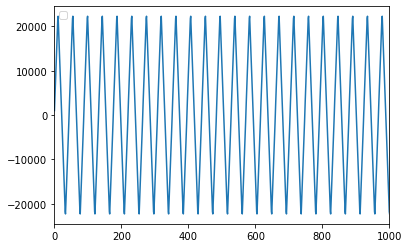

,Unnamed: 0,0
0,0,1025
1,1,3071
2,2,5121
3,3,7168
4,4,9215
...,...,...
253435,253435,-9724
253436,253436,-7684
253437,253437,-5628
253438,253438,-3588


In [4]:
# csv파일 불러오기
pd.DataFrame(audio_samples).to_csv("test.csv")
data = pd.read_csv('test.csv')
# train_data = data['0'].values/1000

# data 정보 출력
print(data['0'].describe())
# train data 그래프 출력
plt.plot(data['0'])
plt.xlim(0,1000)
plt.legend()
plt.show()
data

In [5]:
X = np.arange(len(data)).reshape(-1,1)
y = data['0'].values
y = y.reshape(-1,1)
print("X : \n", X)
print("\ny : \n", y)

X : 
 [[     0]
 [     1]
 [     2]
 ...
 [253437]
 [253438]
 [253439]]

y : 
 [[ 1025]
 [ 3071]
 [ 5121]
 ...
 [-5628]
 [-3588]
 [-1534]]


In [6]:
# 딥러닝 학습을 정상적으로 동작 시키기 위해 데이터 정규화
y_std = y.std()
y_mean = y.mean()
y = (y-y_mean) / y_std
y

array([[ 0.07696672],
       [ 0.23060322],
       [ 0.38454008],
       ...,
       [-0.42261471],
       [-0.26942876],
       [-0.11519153]])

In [7]:
seq_len = 50   #window size : 예측을 위한 데이터 수
prediction = 1  # 다음을 예측할 데이터 수
sequence_length = seq_len + prediction

result = []
for index in range(len(y) - sequence_length):
    result.append(y[index: index + sequence_length])

In [8]:
result = np.array(result)
row = int(round(result.shape[0] * 0.1))
train = result[:row, :]

In [9]:
# 현재를 기준으로 최근 50개 데이터를 시험에 사용하고 그 외의 이전 데이터들은 학습에 사용
test_period = 50

X_train = train[:, :-prediction]
y_train = train[:,-prediction]
X_test = result[row:, :-prediction]
y_test = result[row:, -prediction]

print("shape of X_train : ", X_train.shape)
print("shape of y_train : ", y_train.shape)
print("shape of X_test : ", X_test.shape)
print("shape of y_test : ", y_test.shape)

shape of X_train :  (25339, 50, 1)
shape of y_train :  (25339, 1)
shape of X_test :  (228050, 50, 1)
shape of y_test :  (228050, 1)


In [10]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("shape of X_train : ", X_train.shape) 
print("shape of X_test : ", X_test.shape)

shape of X_train :  (25339, 50, 1)
shape of X_test :  (228050, 50, 1)


In [11]:
# 모델 생성
print('Build LSTM RNN model ...')
model = Sequential()

# LSTM layer
model.add(LSTM(50, return_sequences=True, input_shape=(50,1)))  # (timestep, feature)
model.add(LSTM(64, return_sequences=False))

# Output(Dense) : 1개 
model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='rmsprop')
model.summary()

Build LSTM RNN model ...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


In [12]:
%%time 
# 트레이닝 값으로 학습
print ("training started..... please wait.")
hist = model.fit(X_train, y_train, epochs = 3, batch_size=10, validation_data=(X_test, y_test))

# 모델 저장
model.save('weight.h5')
print ("training finised!")

training started..... please wait.
Epoch 1/3
2534/2534 [==============================] - 194s 75ms/step - loss: 0.0169 - val_loss: 7.3083e-04
Epoch 2/3
2534/2534 [==============================] - 190s 75ms/step - loss: 9.6274e-04 - val_loss: 1.3731e-04
Epoch 3/3
2534/2534 [==============================] - 193s 76ms/step - loss: 4.6811e-04 - val_loss: 5.6297e-05
training finised!
Wall time: 9min 37s


<function matplotlib.pyplot.show(close=None, block=None)>

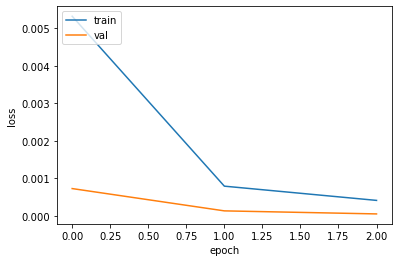

In [13]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show

In [14]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
testScore = model.evaluate(X_test, y_test, verbose=0)

print('Train Score : ', trainScore)
print('Test Score : ', testScore)

Train Score :  5.6305732869077474e-05
Test Score :  5.6296736147487536e-05


In [15]:
pred = model.predict(X_test)

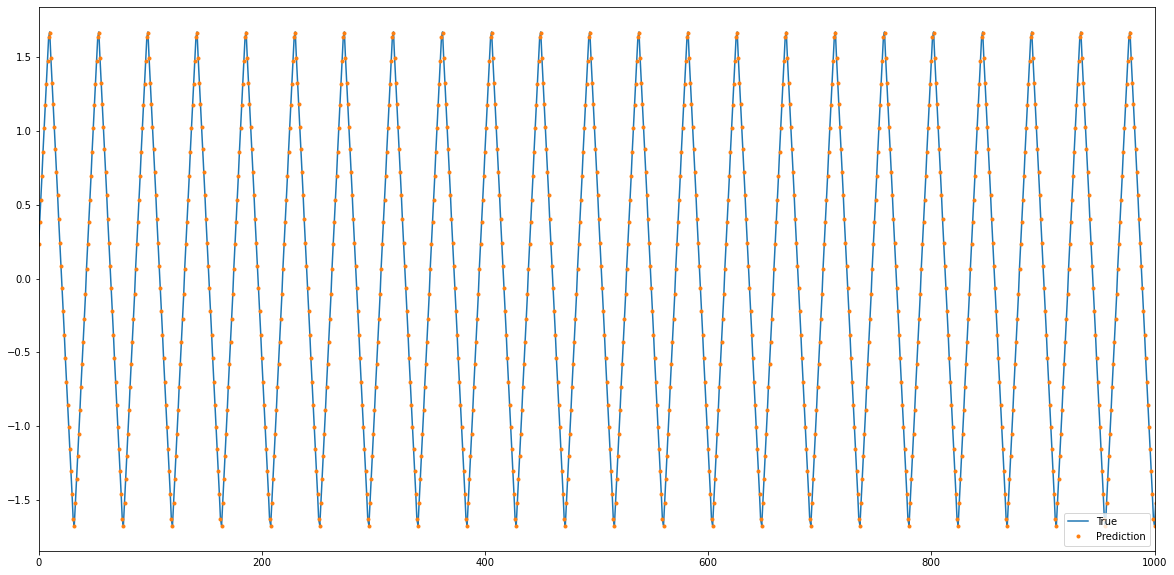

In [16]:
fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, '.', label='Prediction')
ax.legend()
plt.xlim(0,1000)
plt.show()

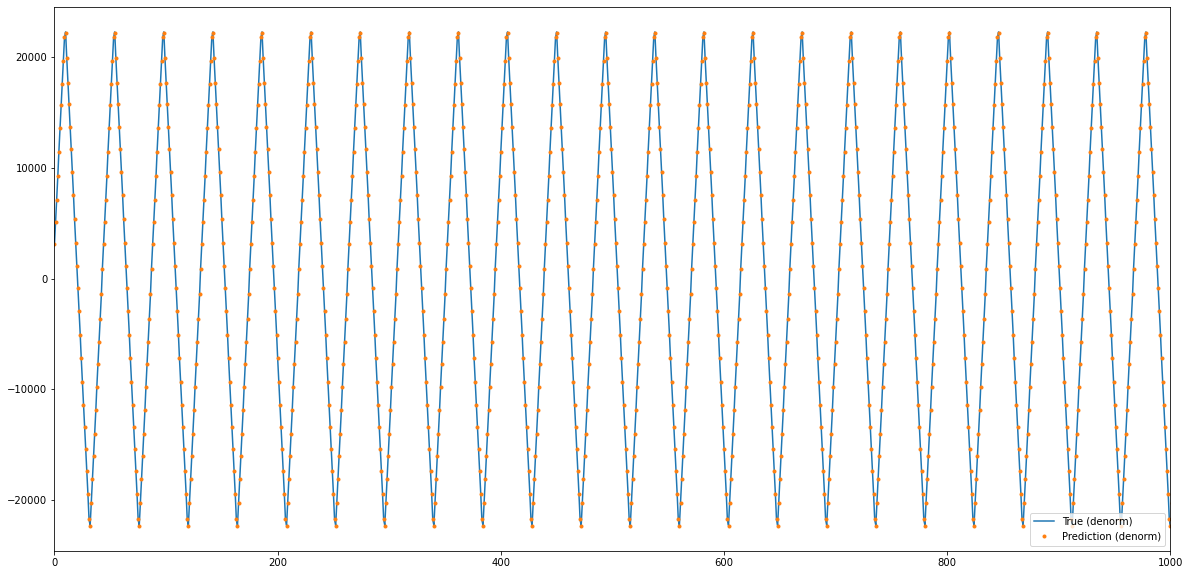

In [17]:
# 정규화된 데이터를 복원하기 위해 사용하는 함수
def denorm(y):
    return y * y_std + y_mean

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(denorm(y_test), label='True (denorm)')
ax.plot(denorm(pred), '.', label='Prediction (denorm)')
ax.legend()
plt.xlim(0,1000)
plt.show()

In [18]:
denorm_pred = denorm(pred)

In [19]:
wavfile.write("pred.wav", EXPECTED_SAMPLE_RATE, pred)

In [20]:
ipd.Audio("pred.wav")

In [21]:
pd.DataFrame(denorm_pred).to_csv("Pred.csv")